In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, grad, vmap
import matplotlib.pyplot as plt
import qcsys as qs
import jax.numpy as jnp
from rar_helpers import *

In [3]:
import jaxquantum as jqt

In [4]:
# Analytic calculation of relevant metrics
ϕ0, metrics0, system0 = get_metrics_linear_rar({})
metrics0

{'ω_ResonatorA': Array(4.99584201, dtype=float64),
 'ω_ATS': Array(6.02181564, dtype=float64),
 'ω_ResonatorB': Array(7.00151547, dtype=float64),
 'g_ex': Array(-0.00212182+0.j, dtype=complex128),
 'g_3': Array(1.28654004e-05+0.j, dtype=complex128),
 'g_cd': Array(2.57308009e-05+0.j, dtype=complex128)}

In [5]:
# Calculate Kerr in full system
metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({})#{"ResonatorA_frequency": 3})
metrics["K_a"]*1e9

Array([ 0.00000000e+00, -3.55271368e-06,  7.10542736e-06,  0.00000000e+00,
       -1.77635684e-05,  2.84217094e-05], dtype=float64)

In [6]:
# Calculate Kerr in full system
metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({})#{"ResonatorA_frequency": 3})
metrics["K_a"]*1e9

Array([ 0.00000000e+00, -3.55271368e-06,  7.10542736e-06,  0.00000000e+00,
       -1.77635684e-05,  2.84217094e-05], dtype=float64)

In [7]:
# Can override parameters!
metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({
    "ATS__dE_J": 37.0 * 0.01
})
metrics["K_a"]*1e9

Array([ 9.07348863e+00,  9.07284203e+00,  9.07206754e+00,  9.07085607e+00,
       -1.22036106e+01,  4.27481506e+05], dtype=float64)

In [8]:
# Can override parameters!
metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({
    "ATS__dE_J": 37.0 * 0.01
})
metrics["K_a"]*1e9

Array([ 9.07348863e+00,  9.07284203e+00,  9.07206754e+00,  9.07085607e+00,
       -1.22036106e+01,  4.27481506e+05], dtype=float64)

# Relevant Hamiltonian Terms for a Time Dep Simulation

In [9]:
metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({})

In [10]:
H_static = system.get_H()

phi = system.params["phi"]
Ejb = system.devices[1].params["Ej"]
H_drive = -2*Ejb*jqt.sinm(phi)

In [11]:
# The full system Hamiltonian H = H_static + sin(eps(t)) * H_drive
H_static_qt = jqt.jqt2qt(H_static)
H_drive_qt = jqt.jqt2qt(H_drive) 

In [12]:
H_drive_qt # qutip job

Quantum object: dims = [[8, 10, 8], [8, 10, 8]], shape = (640, 640), type = oper, isherm = True
Qobj data =
[[0.         0.69714856 0.         ... 0.         0.         0.        ]
 [0.69714856 0.         0.98587103 ... 0.         0.         0.        ]
 [0.         0.98587103 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         1.39529043 0.        ]
 [0.         0.         0.         ... 1.39529043 0.         1.50720291]
 [0.         0.         0.         ... 0.         1.50720291 0.        ]]

# Run Sweep

### Calculate Metrics

In [9]:
def sweep_function(ATS__E_J):
    ϕ0, metrics0, system0 = get_metrics_linear_rar({
        "ResonatorA_frequency": 5,
        "ResonatorB_frequency": 7,
        "ATS__E_J": ATS__E_J
    })
    metrics = {
        "g_3": metrics0["g_3"],
        "g_cd": metrics0["g_cd"],
    }
    return metrics 

sweep_vmap_function = jit(vmap(sweep_function)) # always jit after vmap, never vmap a jitted function (it'll be slower!)

In [10]:
ATS_Ejs = jnp.linspace(10,50, 101)
metrics = sweep_vmap_function(ATS_Ejs)

/opt/miniconda3/envs/qcsys-error-env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/qcsys-error-env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Interaction Strengths (kHz)')

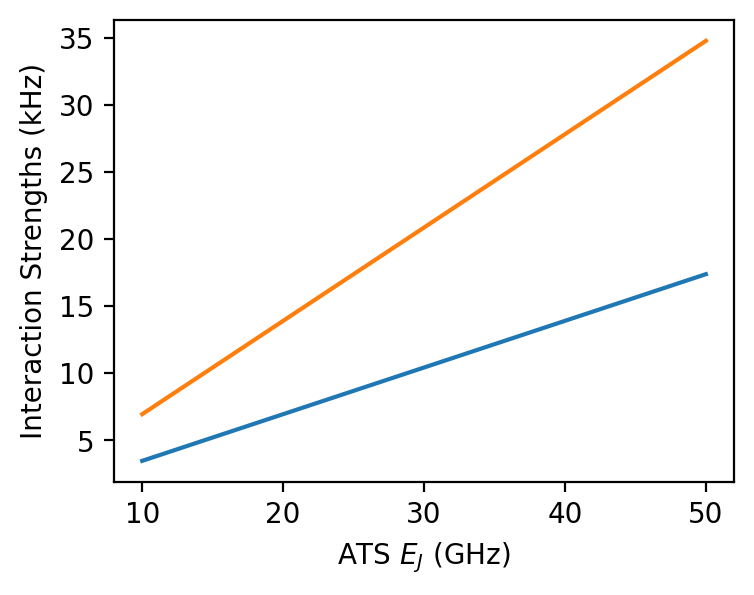

In [11]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(4,3))
ax.plot(ATS_Ejs, metrics["g_3"]*1e6, label="$g_3$")
ax.plot(ATS_Ejs, metrics["g_cd"]*1e6, label="$g_cd$")
ax.set_xlabel("ATS $E_J$ (GHz)")
ax.set_ylabel("Interaction Strengths (kHz)")

### Calculate Kerr

In [17]:
def sweep_function(ATS__E_J):
    metrics, system, ϕ0, metrics0, system0 = get_metrics_normal_rar({
        "ResonatorA_frequency": 5,
        "ResonatorB_frequency": 7,
        "ATS__E_J": ATS__E_J
    })
    metrics_return = {
        "K_a": metrics["K_a"][0],
        "K_b": metrics["K_b"][0]
    }
    return metrics_return 

sweep_vmap_function = jit(vmap(sweep_function)) # always jit after vmap, never vmap a jitted function (it'll be slower!)

In [18]:
ATS_Ejs = jnp.linspace(10,50, 11)
metrics = sweep_vmap_function(ATS_Ejs)

Text(0, 0.5, 'Kerr Strengths (Hz)')

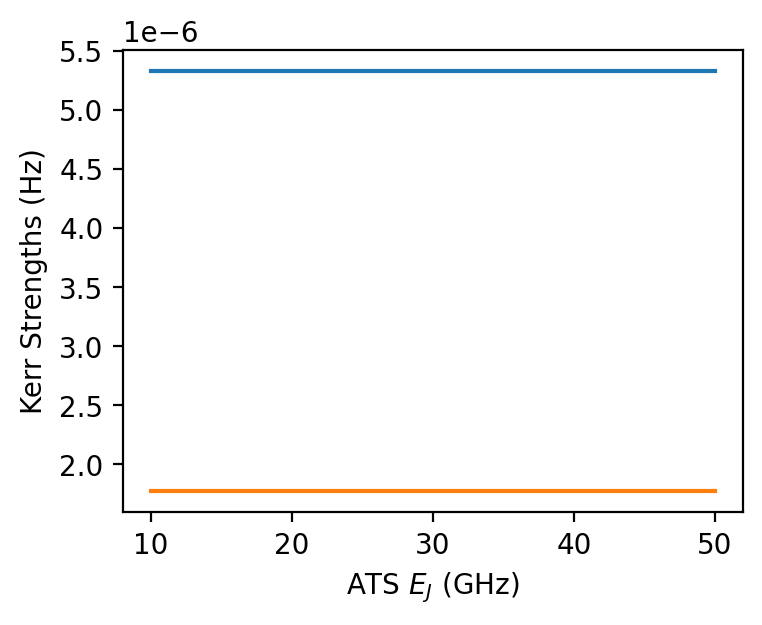

In [21]:
# Near zero Kerr!
fig, ax = plt.subplots(1,1, dpi=200, figsize=(4,3))
ax.plot(ATS_Ejs, metrics["K_a"]*1e9, label="$K_a$")
ax.plot(ATS_Ejs, metrics["K_b"]*1e9, label="$K_b$")
ax.set_xlabel("ATS $E_J$ (GHz)")
ax.set_ylabel("Kerr Strengths (Hz)")